Importing all the required Libraries

In [1]:
# importing the lobraries
import nltk
from nltk.corpus import stopwords
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_is_fitted
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt
import matplotlib
from scipy.sparse import coo_matrix, hstack
from scipy import sparse
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
%matplotlib inline

### 1: Loading the train data and test data from csv files

In [2]:
# loading the data
train_data = pd.read_csv('./data/all/train.csv')
test_data = pd.read_csv('./data/all/test.csv')

Utility classes/functions to extract/prepare the data set

In [1]:
# PrepareData
class PrepareData:
    """
    Class to perpare the data for taraining, and testing 
    The class provide instance and static methods to prepare the data.

    Args:
    data_set : data set
    """

    # get and initialize the dataset
    def __init__(self, data_set):
        self.data_set = data_set

    def split_data(self, train_percent=.7, test_percent=.3, seed=None):
        """ This method split the data into train data set and test data set
        by default it splits the data as train_data = 70% and test_data = 30%

        Args:
        train_percent : percentage of train data, default value - 0.7
                        default:0.7
        test_pecent : percetage of test data, default value - 0.3
                        default:0.3
        seed : None optional

        Returns:
        train_data : tranin data
        test_data : test data
        """

        np.random.seed(seed=seed)
        permuted_test = np.random.permutation(self.data_set.index)
        total_len = len(data_set.index)
        train_end = int(train_percent * total_len)
        test_end = int(test_percent * total_len) + train_end
        train_data = self.data_set.loc[permuted_test[:train_end]]
        test_data = self.data_set.loc[permuted_test[train_end:test_end]]

        return train_data, test_data

    @staticmethod
    def prepare_test_data(labels, data_set):
        """
        Utility method to prepare the test data. 
        This method keeps the lables which are required for testing 
        by removing other lables from data frame

        Args:
        labels : list of expected lables in test data set
        data_set : test data set

        Returns:
        data_set : processed dataset
        """

        deleting_labels = [label for label in list(
            data_set.columns) if label not in labels]
        data_set = data_set.drop(deleting_labels, axis=1)
        return data_set

Looking at the data set before pre processing.

In [4]:
# size of traning and test data sets
len(train_data), len(test_data)

(159571, 153164)

In [5]:
train_data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [6]:
test_data.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [7]:
train_data.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
for index in range(4, 15):
    print(train_data['comment_text'][index])

You, sir, are my hero. Any chance you remember what page that's on?
"

Congratulations from me as well, use the tools well.  · talk "
COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
Your vandalism to the Matt Shirvington article has been reverted.  Please don't do it again, or you will be banned.
Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169
alignment on this subject and which are contrary to those of DuLithgow
"
Fair use rationale for Image:Wonju.jpg

Thanks for uploading Image:Wonju.jpg. I notice the image page specifies that the image is being used under fair use but

We can see the spaces,blank lines and some other special characters in the comment text, if we look into training data its largly blank lines and spaces. Will be removing these as part of data cleaning.

In [9]:
# Global variables
LABELS = list(train_data.columns)  # getting all columns
CLASS_LABELS = LABELS[2:]  # selecting only classes
CLASS_LABELS

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


The training data set is multi-labeled, which means each comment is labeled with one or more classes. So, it is better to have an idea about the number of comments fall in each classes.



toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


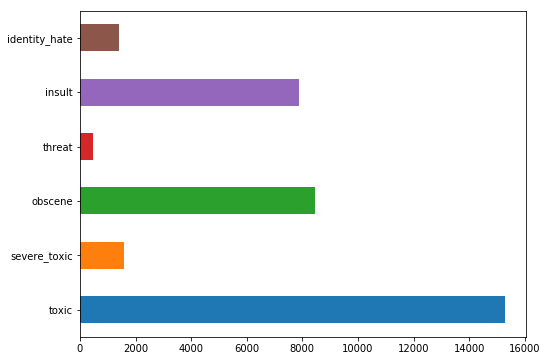

In [62]:
train_class_count = train_data[CLASS_LABELS].sum()
print(train_class_count)
train_class_count.plot.barh(figsize=(8, 6))


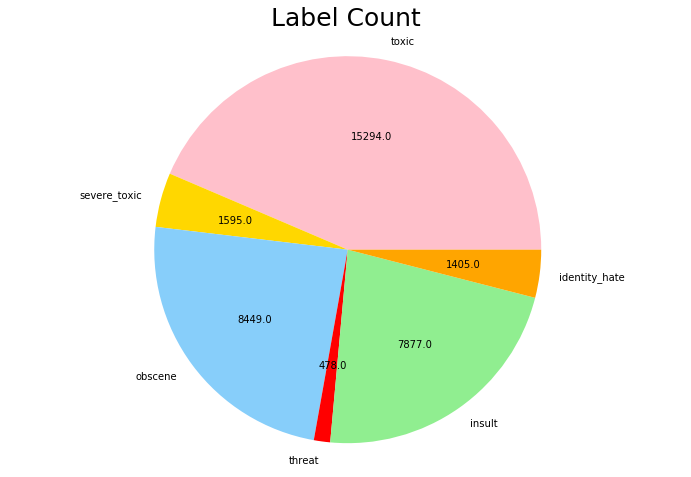

In [72]:
plt.figure(1, figsize=(12,8))
temp = np.asarray(train_class_count)
colors = ['pink', 'gold', 'lightskyblue','red','lightgreen','orange']
plt.pie(temp, labels=CLASS_LABELS, colors=colors,autopct=lambda x: np.round(x/100.*temp.sum(), 0))
plt.axis('equal')
plt.title("Label Count", fontdict={'fontsize':25})

plt.show()

So, there are comments which has no labels. Also, there are comments which have more than one labels. Now, it's time to look at each comment text in the data set.

Total number of characters -  62882658
Longest comment length -  5000
Shortest comment length -  6


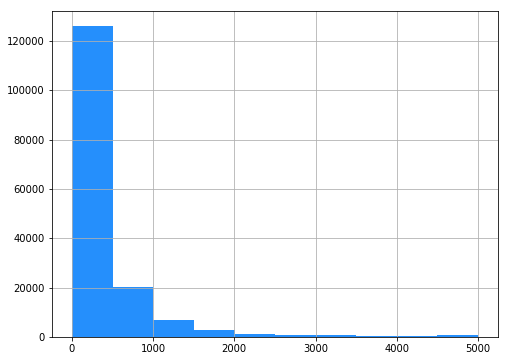

In [12]:
train_tmp_df = train_data
train_tmp_df['comment_length'] = train_tmp_df['comment_text'].apply(
    lambda y: len(str(y)))
print("Total number of characters - ", train_tmp_df['comment_length'].sum())
print("Longest comment length - ", train_tmp_df['comment_length'].max())
print("Shortest comment length - ", train_tmp_df['comment_length'].min())

train_tmp_df['comment_length'].hist(color='#258ffc', figsize=(8, 6))

To compare the train data and test data with respect to the length of comment and its distribution, will perform similar operations on test data set.

Total number of characters -  55885733
Longest comment length -  5000
Shortest comment length -  1


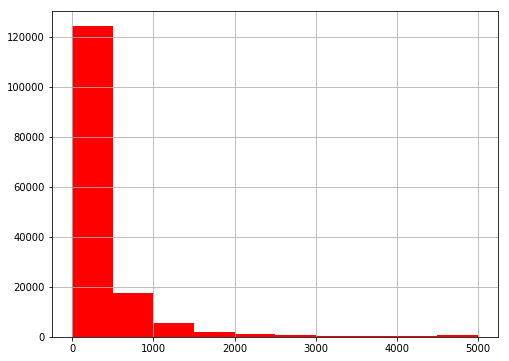

In [13]:
test_tmp_df = test_data
test_tmp_df['comment_length'] = test_tmp_df['comment_text'].apply(
    lambda t: len(str(t)))
print("Total number of characters - ", test_tmp_df['comment_length'].sum())
print("Longest comment length - ", test_tmp_df['comment_length'].max())
print("Shortest comment length - ", test_tmp_df['comment_length'].min())

test_tmp_df['comment_length'].hist(color='red', figsize=(8, 6))

Now, the shape of comment and its length distribution looks similar between the training data and the train data. Next step is clean the data.

### 2. Cleaning the train and test data

In [14]:
class CleanData:
    """
    Utiliy class to clean the data. provides instance and static methods 
    for cleaning the train/test data

    Args:
    data_set : data set to be cleaned. 
    """

    def __init__(self, data_set):
        self.data_set = data_set

    def fill_null(self):
        """
        Method to fill all the null values in the data set

        Args:

        Returns:
        data_set : data set with non null values

        """
        self.data_set.fillna(' ')
        return self.data_set

    def clean_text(self, field):
        """
        Method to clean the text data. 

        Args:
        field : class label in the data set

        Returns:
        data_set : cleaned data set

        """
        self.data_set[field] = self.data_set[field].str.replace(r"http\S+", "")
        self.data_set[field] = self.data_set[field].str.replace(r"http", "")
        self.data_set[field] = self.data_set[field].str.replace(r"@\S+", "")
        self.data_set[field] = self.data_set[field].str.replace(
            r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"@", "at")
        self.data_set[field] = self.data_set[field].str.replace(
            r"what's", "what is")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'ve", " have")
        self.data_set[field] = self.data_set[field].str.replace(
            r"can't", "can not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"don't", "do not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"weren't", "were not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"doesn't", "does not")
        self.data_set[field] = self.data_set[field].str.replace(
            r"i'm", "i am ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'re", " are ")
        self.data_set[field] = self.data_set[field].str.replace(
            r"\'d", " would ")
        self.data_set[field] = self.data_set[field].str.replace(r"\'s", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"\W", " ")
        self.data_set[field] = self.data_set[field].str.replace(r"\s+", " ")
        self.data_set[field] = self.data_set[field].str.lower()
        return self.data_set

    def remove_stop_words(self, field):
        """
        Method to remove the stopwords from the text.

        Args:
        field: class label in the dataset

        Returns:
        data_set : data set without stopwords.
        """
        self.data_set[field].apply(lambda x: ' '.join(
            [word for word in x.split() if word not in stopwords.words('english')]))
        return self.data_set

    def get_text(self, field):
        """
        Utility method to get particular column from data set

        Args:
        field : name of the required field

        Returns:
        data_set : returns the text of metioned field
        """

        return self.data_set[field]

    @staticmethod
    def get_all_text(data_set_one, data_set_two, field):
        """
        Static method to combine a particular column of two data sets.

        Args:
        data_set_one : data frame 
        data_set_two : data frame
        field : column name 

        Returns:
        data_set : new data set

        """
        data_set = pd.concat([data_set_one[field], data_set_two[field]])
        return data_set

    @staticmethod
    def get_all_text(data_set_one, data_set_two):
        """
        Static method to combine two data sets.

        Args:
        data_set_one : first data set of type data frame
        data_set_two : second data set of type 

        Returns:
        data_set_merged : new combined data set
        """
        data_set_merged = pd.concat([data_set_one, data_set_two])
        return data_set_merged

The above class CleanData provides couple of methods to perform the data cleaning both on train and test data.CleanData class also defined some static methods to combine the data sets.

Cleaning the train and test data

In [15]:
clean_train_data = CleanData(train_data)
train_text = clean_train_data.fill_null()
train_text = clean_train_data.get_text('comment_text')

In [16]:
train_text.shape, type(train_text)

((159571,), pandas.core.series.Series)

In [17]:
train_text.head()

0    Explanation\nWhy the edits made under my usern...
1    D'aww! He matches this background colour I'm s...
2    Hey man, I'm really not trying to edit war. It...
3    "\nMore\nI can't make any real suggestions on ...
4    You, sir, are my hero. Any chance you remember...
Name: comment_text, dtype: object

In [18]:
clean_test_data = CleanData(test_data)
test_text = clean_test_data.fill_null()
test_text = clean_test_data.get_text('comment_text')

In [19]:
test_text.shape, type(test_text)

((153164,), pandas.core.series.Series)

In [20]:
test_text.head()

0    Yo bitch Ja Rule is more succesful then you'll...
1    == From RfC == \n\n The title is fine as it is...
2    " \n\n == Sources == \n\n * Zawe Ashton on Lap...
3    :If you have a look back at the source, the in...
4            I don't anonymously edit articles at all.
Name: comment_text, dtype: object

In [21]:
full_text = CleanData.get_all_text(
    data_set_one=train_text, data_set_two=test_text)

### 3. Feature Implementation, Build and Train Model

In [22]:
class WordVectorizer:
    """
    WordVectorizer class provides methods to perform vectorization for words

    Args:
    data_set : input data set

    """

    def __init__(self, data_set):
        self.data_set = data_set

    def word_vector(self, ngram_value=1):
        """

        word_vector method generates the Tfidf vector for the data set. 
        It accepts an optinal parameter to specify the ngram value.

        Args:
        ngram_value : n gram value, default:1.

        Returns:
        word_vec : Tfidf vector.

        """
        word_vec = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode',
                                   analyzer='word', token_pattern=r'\w{1,}',
                                   stop_words='english', ngram_range=(1, ngram_value),
                                   max_features=10000)
        word_vec.fit(self.data_set)
        return word_vec

Above class provides method to get the trem documents for words. Also, implemented ngram feature before Tfidf vectorization. We can dynamically specify the ngram feature to its method.

In [23]:
class CharVectorizer:
    """
    CharVectorizer class provides methods to perform character level ngram and Tfidf.

    Args:
    data_set : input data set

    """

    def __init__(self, data_set):
        self.data_set = data_set

    def char_vector(self):
        """
        char_vector method generates the Tfidf vector for the data set. 

        Returns:
        char_vec : Tfidf vector.

        """

        char_vec = TfidfVectorizer(sublinear_tf=True, strip_accents='unicode',
                                   analyzer='char', stop_words='english',
                                   ngram_range=(4, 6), max_features=50000)
        char_vec.fit(self.data_set)
        return char_vec

The above class is to implement the character level n-gram and then generate the term frequency vector. This help to find out the hidden toxic characters or group of characters which are usually found within a word. 

In [24]:
# word_vectorizer = WordVectorizer(full_text)
word_vectorizer = WordVectorizer(train_text)
word_vec = word_vectorizer.word_vector()

In [25]:
train_word_features = word_vec.transform(train_text)

In [26]:
test_word_features = word_vec.transform(test_text)

In [27]:
# char_vectorizer = CharVectorizer(full_text)
char_vectorizer = CharVectorizer(train_text)
char_vec = char_vectorizer.char_vector()
train_char_features = char_vec.transform(train_text)
test_char_features = char_vec.transform(test_text)

In [28]:
train_target = CleanData(train_data).fill_null()
train_features = hstack([train_char_features, train_word_features])
type(train_target), type(train_features)

(pandas.core.frame.DataFrame, scipy.sparse.coo.coo_matrix)

In [29]:
train_target.shape, train_features.shape,train_char_features.shape

((159571, 9), (159571, 60000), (159571, 50000))

Combining both the word features and character level fetures for both train and test data.

In [30]:
# combine both char level features and word level features
train_features = hstack([train_char_features, train_word_features])
test_features = hstack([test_char_features, test_word_features])
train_features.shape

(159571, 60000)

Defining the classifier Logistic Regression with Naive Bayes features.

In [31]:
class NbLogRegClassifier(BaseEstimator, ClassifierMixin):

    """
    The Logistic Regression classifier makes use of basic Naive Bayes feature.
    The classifier inherits from BaseEstimator and ClassifierMixin sklearn's base package.

    Args:
    C :  Inverse of regularization strength; must be a positive float. 
        Like in support vector machines, smaller values specify stronger regularization.
        default: 1.0
    solver : Algorithm to use in the optimization problem.
            default: 'sag'
            prefered for multiclass problem - 'newton-cg’, ‘sag’, ‘saga’ or ‘lbfgs'
    n_jobs : Number of CPU cores used when parallelizing over classes if multi_class=’ovr’”.
            default: -1 (using all processors)
    max_iter : Maximum number of iterations taken for the solvers to converge.
            default: 4000
    dual: Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. 
          Prefer dual=False when n_samples > n_features.
          default: False

    """

    def __init__(self, C=4, dual=False, n_jobs=-1, solver='sag', max_iter=4000):
        self.C = C
        self.dual = dual
        self.n_jobs = n_jobs
        self.max_iter = max_iter
        self.solver = solver

    def predict(self, X):
        """

        Predict class labels for samples in X.

        Args:
        X : array_like or sparse matrix, shape (n_samples, n_features)

        Returns:

        C : array, shape [n_samples]
            Predicted class label per sample.

        """
        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict(X.multiply(self._r))

    def predict_proba(self, X):
        """

        Probability estimates.

        The returned estimates for all classes are ordered by the
        label of classes.

        Args:
        X : array-like, shape = [n_samples, n_features]

        Returns:
        T : 

        """

        check_is_fitted(self, ['_r', '_clf'])
        return self._clf.predict_proba(X.multiply(self._r))

    def fit(self, X, y):
        """

        Fit the model according to the given training data.

        Args:
        X : {array-like, sparse matrix}, shape (n_samples, n_features)
            Training vector, where n_samples is the number of samples and n_features is the number of features.
        y : array-like, shape (n_samples,) or (n_samples, n_targets)
            Target vector relative to X.
        sample_weight : array-like, shape (n_samples,) optional
                        Array of weights that are assigned to individual samples. 
                        If not provided, then each sample is given unit weight.

        Returns:
        self : object

        """

        y = y.values
        X, y = check_X_y(X, y, accept_sparse=True)

        def pr(X, y_i, y):
            """
            Method to implement the basic Naive Bayes feature
            """
            p = X[y == y_i].sum(0)
            return (p+1) / ((y == y_i).sum()+1)

        self._r = sparse.csr_matrix(np.log(pr(X, 1, y) / pr(X, 0, y)))
        x_nb = X.multiply(self._r)
        self._clf = LogisticRegression(
            C=self.C, dual=self.dual, n_jobs=self.n_jobs).fit(x_nb, y)
        return self

A miscellanious utility class.

In [32]:
class Utility:

    """
    The utility class which provides static methods to perform some miscellanious operations.
    """

    @staticmethod
    def compare_models(md1_acc, md1_name, md2_acc, md2_name, title=None):
        """
        Static method takes the accuracy/cv score of two models and generate comparision graph

        Args:
        md1_acc : Accuracy score/ CV score of model 1, preferred- pandas Series
        md1_name : Name for the first model
        md2_acc : Accuracy score/ CV score of model 1, preferred- pandas Series
        md2_name : Name for the first model
        title : (optional) Title for the comparision.

        Returns: my_plot of type matplotlib's pyplot.
        """

        md1_acc = md1_acc.mul(100, axis=0)
        md2_acc = md2_acc.mul(100, axis=0)
        df = pd.DataFrame(md1_acc, columns=[md1_name])
        df[md2_name] = md2_acc
        my_plot = df.plot(kind='bar', figsize=(12, 10),
                          legend=True, grid=True, title=title, stacked=False)
        my_plot.set_xlabel("Classes")
        my_plot.set_ylabel("Accuracy")
        return my_plot

### 4. Validating the Model

Will train and validate the model.

Naive Bayes

In [33]:
nb_accuracy = {}
for label in CLASS_LABELS:
    train_target = CleanData(train_data).fill_null()
    train_target = train_target[label]
    nb = MultinomialNB()

    cv_score = np.mean(cross_val_score(nb, train_features,
                                       train_target, cv=3, scoring='roc_auc'))
    nb_accuracy[label] = cv_score

nb_accuracy['mdl_accuracy'] = np.mean(list(nb_accuracy.values()))
print('CV score using Naive Bayes - {}'.format(np.mean(list(nb_accuracy.values()))))


CV score using Naive Bayes - 0.951504285370503


Text(0,0.5,'Accuracy')

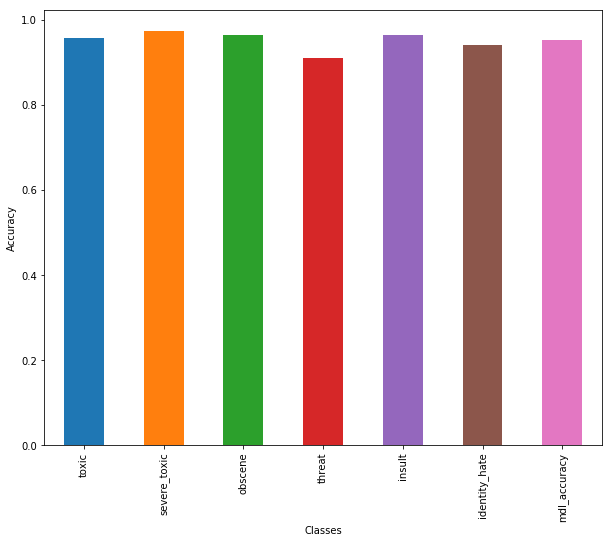

In [34]:
nb_accuracy = pd.Series(nb_accuracy)
my_plot = nb_accuracy.plot(kind='bar', figsize=(10, 8))
my_plot.set_xlabel("Classes")
my_plot.set_ylabel("Accuracy")

Logistic Regression with simple Naive Bayes feature

In [35]:
nb_logreg_accuracy = {}
for label in CLASS_LABELS:
    train_target = CleanData(train_data).fill_null()
    train_target = train_target[label]
    nb_logreg = NbLogRegClassifier(C=4, dual=False, n_jobs=-1, solver='sag', max_iter=2000)

    cv_score = np.mean(cross_val_score(nb_logreg, train_features,
                                       train_target, cv=3, scoring='roc_auc'))
    nb_logreg_accuracy[label] = cv_score

nb_logreg_accuracy['mdl_accuracy'] = np.mean(list(nb_logreg_accuracy.values()))
print('CV score for NbLogReg - {}'.format(np.mean(list(nb_logreg_accuracy.values()))))


CV score for NbLogReg - 0.9813156091458337


Text(0,0.5,'Accuracy')

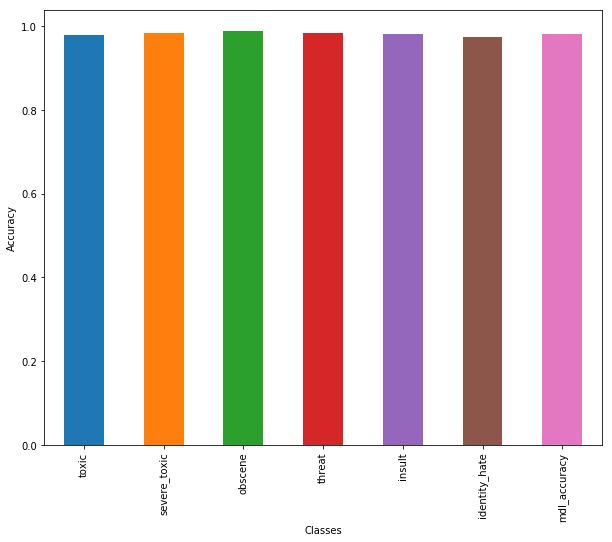

In [36]:
nb_logreg_accuracy = pd.Series(nb_logreg_accuracy)
my_plot = nb_logreg_accuracy.plot(kind='bar', figsize=(10, 8))
my_plot.set_xlabel("Classes")
my_plot.set_ylabel("Accuracy")

Comparing both the models

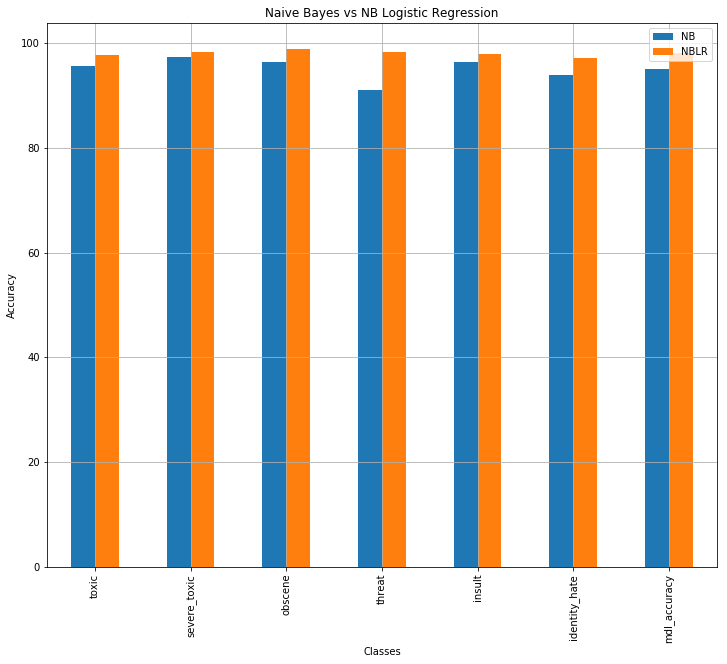

In [37]:
Utility.compare_models(md1_acc=nb_accuracy,md1_name="NB", md2_acc=nb_logreg_accuracy, md2_name="NBLR",title="Naive Bayes vs NB Logistic Regression")